<a href="https://colab.research.google.com/github/victwise/fastai_numerical_linear_algebra/blob/master/Cap%C3%ADtulo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sources:
- http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html
- https://people.csail.mit.edu/indyk/princeton.pdf
- https://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html
- http://www.cs.colostate.edu/~mcrob/toolbox/c++/sparseMatrix/sparse_matrix_compression.html

# Detección comprimida de tomografías computarizadas con regresión robusta

##Broadcasting
El término **broadcasting** o difusión describe cómo se tratan las matrices con diferentes formas durante las operaciones aritméticas. El término difusión fue utilizado por primera vez por Numpy, aunque ahora se usa en otras bibliotecas como Tensorflow y Matlab; Las reglas pueden variar según la biblioteca.

In [0]:
import numpy as np

In [3]:
a  =  np . array ([ 1.0 ,  2.0 ,  3.0 ]) 
b  =  2.0 
a  *  b

array([2., 4., 6.])

In [4]:
v=np.array([1,2,3])
print(v, v.shape)

[1 2 3] (3,)


In [5]:
m=np.array([v,v*2,v*3]); m, m.shape

(array([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]]), (3, 3))

In [0]:
n = np.array([m*1, m*5])

In [7]:
n

array([[[ 1,  2,  3],
        [ 2,  4,  6],
        [ 3,  6,  9]],

       [[ 5, 10, 15],
        [10, 20, 30],
        [15, 30, 45]]])

In [8]:
n.shape, m.shape

((2, 3, 3), (3, 3))

Podemos usar broadcasting para sumar una matriz y un array:

In [9]:
m+v

array([[ 2,  4,  6],
       [ 3,  6,  9],
       [ 4,  8, 12]])

Notese que hacemos si usamos la transposicion de un array.

In [11]:
v1=np.expand_dims(v,-1); v1, v1.shape

(array([[1],
        [2],
        [3]]), (3, 1))

In [12]:
m+v1

array([[ 2,  3,  4],
       [ 4,  6,  8],
       [ 6,  9, 12]])

## **Reglas Generales de Emisión Numpy **
Cuando se opera en dos matrices, NumPy compara sus formas de manera elemental. Comienza con las dimensiones finales , y se abre camino hacia adelante. Dos dimensiones son compatibles cuando

son iguales, o
uno de ellos es 1

Las matrices no necesitan tener el mismo número de dimensiones. Por ejemplo, si tienes una matriz de 256 × 256 × 3 de valores RGB, y desea escalar cada color en la imagen por un valor diferente, puede multiplicar la imagen por una matriz unidimensional con 3 valores. Alinear los tamaños de los ejes finales de estas matrices de acuerdo con las reglas de transmisión, muestra que son compatibles:

Image  (3d array): 256 x 256 x 3

Scale  (1d array):             3

Result (3d array): 256 x 256 x 3

In [0]:
v = np.array([1,2,3,4])
m = np.array([v,v*2,v*3])
A = np.array([5*m, -1*m])

In [14]:
v.shape, m.shape, A.shape

((4,), (3, 4), (2, 3, 4))

In [15]:
A

array([[[  5,  10,  15,  20],
        [ 10,  20,  30,  40],
        [ 15,  30,  45,  60]],

       [[ -1,  -2,  -3,  -4],
        [ -2,  -4,  -6,  -8],
        [ -3,  -6,  -9, -12]]])

In [17]:
A+v

array([[[ 6, 12, 18, 24],
        [11, 22, 33, 44],
        [16, 32, 48, 64]],

       [[ 0,  0,  0,  0],
        [-1, -2, -3, -4],
        [-2, -4, -6, -8]]])

In [18]:
A

array([[[  5,  10,  15,  20],
        [ 10,  20,  30,  40],
        [ 15,  30,  45,  60]],

       [[ -1,  -2,  -3,  -4],
        [ -2,  -4,  -6,  -8],
        [ -3,  -6,  -9, -12]]])

In [19]:
A.T.shape

(4, 3, 2)

In [20]:
A.T

array([[[  5,  -1],
        [ 10,  -2],
        [ 15,  -3]],

       [[ 10,  -2],
        [ 20,  -4],
        [ 30,  -6]],

       [[ 15,  -3],
        [ 30,  -6],
        [ 45,  -9]],

       [[ 20,  -4],
        [ 40,  -8],
        [ 60, -12]]])

Este ejemplo muestra la reconstrucción de una imagen a partir de un conjunto de proyecciones paralelas, adquiridas en diferentes ángulos. Dicho conjunto de datos se adquiere en tomografía computarizada (TC).

Sin información previa sobre la muestra, el número de proyecciones necesarias para reconstruir la imagen es del orden del tamaño lineal lde la imagen (en píxeles). Para simplificar, consideramos aquí una imagen dispersa, donde solo los píxeles en el límite de los objetos tienen un valor distinto de cero. Tales datos podrían corresponder, por ejemplo, a un material celular. Sin embargo, tenga en cuenta que la mayoría de las imágenes son dispersas en una base diferente, como las wavelets de Haar. Solo l/7se adquieren proyecciones, por lo tanto, es necesario utilizar la información previa disponible en la muestra (su escasez): este es un ejemplo de detección por compresión .

La operación de proyección tomográfica es una transformación lineal. Además del término de fidelidad de datos correspondiente a una regresión lineal, penalizamos la norma L1 de la imagen para dar cuenta de su escasez. El problema de optimización resultante se llama el lazo . Usamos la clase sklearn.linear_model.Lasso, que usa el algoritmo de descenso de coordenadas. Es importante destacar que esta implementación es más eficiente computacionalmente en una matriz dispersa, que el operador de proyección utilizado aquí.

La reconstrucción con penalización L1 da un resultado con cero error (todos los píxeles se etiquetan con éxito con 0 o 1), incluso si se agregó ruido a las proyecciones. En comparación, una penalización L2 ( sklearn.linear_model.Ridge) produce una gran cantidad de errores de etiquetado para los píxeles. Se observan artefactos importantes en la imagen reconstruida, contrariamente a la penalización L1. Tenga en cuenta en particular el artefacto circular que separa los píxeles en las esquinas, que han contribuido a menos proyecciones que el disco central.

In [0]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, math
from scipy import ndimage, sparse

In [0]:
np.set_printoptions(suppress=True)

In [0]:
def generate_synthetic_data():
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mx,my = rs.randint(0, l, (2,n_pts))
    mask = np.zeros((l, l))
    mask[mx,my] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = (mask > mask.mean()) & mask_outer
    return res ^ ndimage.binary_erosion(res)

In [0]:
l = 128
data = generate_synthetic_data()

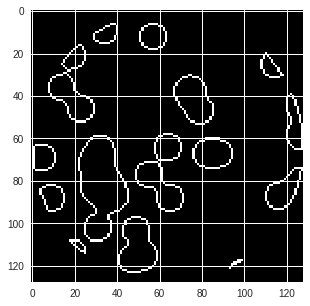

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(data, cmap=plt.cm.gray);

In [0]:
l=8; n_pts=5
rs = np.random.RandomState(0)

In [27]:
x, y = np.ogrid[0:l, 0:l]; x,y

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), array([[0, 1, 2, 3, 4, 5, 6, 7]]))

In [28]:
x+y

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14]])

In [29]:
(x - l/2) ** 2 

array([[16.],
       [ 9.],
       [ 4.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 4.],
       [ 9.]])

In [30]:
(x - l/2) ** 2 + (y - l/2) ** 2

array([[32., 25., 20., 17., 16., 17., 20., 25.],
       [25., 18., 13., 10.,  9., 10., 13., 18.],
       [20., 13.,  8.,  5.,  4.,  5.,  8., 13.],
       [17., 10.,  5.,  2.,  1.,  2.,  5., 10.],
       [16.,  9.,  4.,  1.,  0.,  1.,  4.,  9.],
       [17., 10.,  5.,  2.,  1.,  2.,  5., 10.],
       [20., 13.,  8.,  5.,  4.,  5.,  8., 13.],
       [25., 18., 13., 10.,  9., 10., 13., 18.]])

In [31]:
mask_outer = (x - l/2) ** 2 + (y - l/2) ** 2 < (l/2) ** 2; mask_outer

array([[False, False, False, False, False, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True, False]])

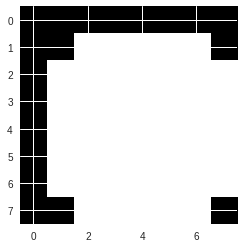

In [32]:
plt.imshow(mask_outer, cmap='gray')

In [33]:
mask = np.zeros((l, l))
mx,my = rs.randint(0, l, (2,n_pts))
mask[mx,my] = 1; mask

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

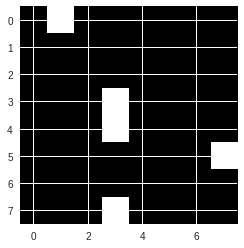

In [34]:
plt.imshow(mask, cmap='gray')

In [0]:
mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)

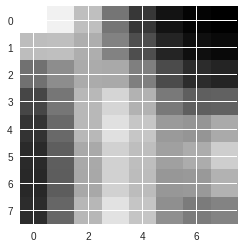

In [36]:
plt.imshow(mask, cmap='gray')

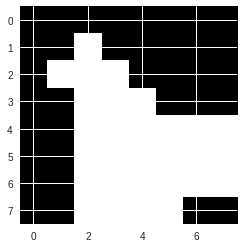

In [37]:
res = np.logical_and(mask > mask.mean(), mask_outer)
plt.imshow(res, cmap='gray');

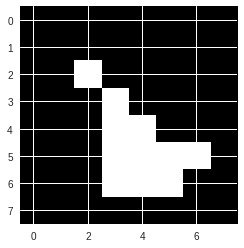

In [38]:
plt.imshow(ndimage.binary_erosion(res), cmap='gray');

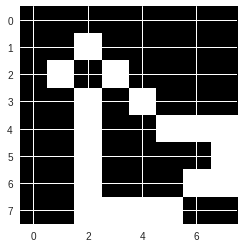

In [39]:
plt.imshow(res ^ ndimage.binary_erosion(res), cmap='gray');

Generando Proyecciones

In [0]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

In [0]:
def build_projection_operator(l_x, n_dir):
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = (inds >= 0) & (inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))

Operador de proyeccion

In [0]:
l = 128

In [0]:
proj_operator = build_projection_operator(l, l//7)

In [0]:
proj_operator